Clean and add possibility to obtain galaxy image and PSF direclty from butler 

# Load libraries

In [1]:
#### Import librairies
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import collections
from importlib import reload

sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import cutout_img_dc2
from tools_for_VAE import plot
#import tools_for_VAE.layers as layers
#from tools_for_VAE import utils, vae_functions, generator, model
#from tensorflow.keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs
import fitsio

import lsst.afw.geom as afw_geom
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import GCRCatalogs
import lsst.geom

In [3]:
from astropy.io import fits
import warnings
import healpy as hp
from collections import namedtuple
from astropy.table import Table

In [4]:
import os
import numpy as np

from astropy.table import Table

import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.geom

from astropy.visualization import ZScaleInterval

#from desc_dc2_dm_data import REPOS

In [5]:
# Set plotting to 'inline' figures
# If you're running on directly in Jupyter and not JupyterLab
# you can instead use the interactive figure interface (nbAgg).
%matplotlib inline
# %matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)
zscale = ZScaleInterval()

# Test with GCR Catalogs

## Read in observed catalog

In [16]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd')#run2.2i-coadd-wfd-dr6-v1

In [18]:
gc_obs.list_all_quantities(include_native=True)

['modelfit_DoubleShapeletPsfApprox_0_5',
 'z_undeblended_ext_convolved_ConvolvedFlux_flag',
 'u_slot_PsfShape_xy',
 'g_base_CircularApertureFlux_17_0_flag',
 'r_slot_ModelFlux_flag_region_maxBadPixelFraction',
 'u_undeblended_ext_photometryKron_KronFlux_instFlux',
 'u_ext_convolved_ConvolvedFlux_2_6_0_flag_apertureTruncated',
 'i_ext_convolved_ConvolvedFlux_2_kron_flag_apCorr',
 'y_base_SdssCentroid_flag_noSecondDerivative',
 'r_undeblended_base_CircularApertureFlux_50_0_flag',
 'modelfit_CModel_initial_nIter',
 'i_base_TransformedCentroid_x',
 'u_ext_convolved_ConvolvedFlux_3_3_3_instFlux',
 'y_ext_convolved_ConvolvedFlux_2_3_3_instFluxErr',
 'r_undeblended_base_CircularApertureFlux_25_0_flag',
 'i_base_PixelFlags_flag_clippedCenter',
 'g_undeblended_base_PsfFlux_flag_noGoodPixels',
 'base_SdssShape_psf_xx',
 'r_ext_convolved_ConvolvedFlux_1_3_3_flag_apertureTruncated',
 'z_base_TransformedShape_flag',
 'i_slot_ModelFlux_flag_noShapeletPsf',
 'base_PsfFlux_flag_badCentroid_badError',


## Match with true catalog

In [13]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [15]:
gc.list_all_quantities(include_native=True)

['sed_13177_1966',
 'sed_8846_549_disk_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_4299_266:rest:dustAtlas',
 'SDSS_filters/totalLuminositiesStellar:SDSS_i:observed:dustAtlas',
 'sed_7843_486_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_r:observed:dustAtlas',
 'baseDC2/target_halo_y',
 'SEDs/diskLuminositiesStellar:SED_9978_1489:rest',
 'SEDs/spheroidLuminositiesStellar:SED_7385_458:rest',
 'emissionLines/diskLineLuminosity:sulfurII6716',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:rest',
 'SEDs/diskLuminositiesStellar:SED_3590_222:rest:dustAtlas',
 'A_v_bulge',
 'SEDs/spheroidLuminositiesStellar:SED_5467_339:rest',
 'ellipticity_2_disk_true',
 'LSST_filters/spheroidLuminositiesStellar:LSST_y:rest:dustAtlas',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_r:observed',
 'mag_u_sdss_no_host_extinction',
 'LSST_filters/totalLuminositiesStellar:LSST_g:observed',
 'otherLuminosities/diskLuminositiesStellar:OxygenContinuum:rest:dustAtlas',
 'magnif

Select data from the right tract and apply the cut in magnitude

In [25]:
# Let's also define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < 26.5',
]

In [26]:
# Load ra and dec from object, using both of the filters we just defined.
object_data = gc_obs.get_quantities(['ra', 'dec', 'mag_r','mag_r_cModel' , 
                                     'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'],
                                        filters=(mag_filters), native_filters=['tract == 4855'])

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs-1.0.1-py3.7.egg/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs-1.0.1-py3.7.egg/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Now use the data from the observe catalog to apply filter in position and magnitude on true filter

In [27]:
max_ra = np.nanmax(object_data['ra'])
min_ra = np.nanmin(object_data['ra'])
max_dec = np.nanmax(object_data['dec'])
min_dec = np.nanmin(object_data['dec'])
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

truth_mag_filters = ['mag_r < 26.5']
quantities = ['galaxy_id', 'ra', 'dec', 
              'mag_r', 'mag_r_lsst',
              'redshift',
              'ellipticity_true', 'convergence',
              'ellipticity_1_true', 'ellipticity_2_true', 
              'shear_1', 'shear_2']
truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

Match the catalogs

In [28]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=0.1, # Linking length of 1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)

In [33]:
len(truth_data['ra']), len(object_data['ra'])

(720922, 604159)

In [34]:
len(truth_data['ra'])+len(object_data['ra'])

1325081

In [35]:
results

<Table length=1325081>
row_index catalog_key group_id
  int64       str6     int64  
--------- ----------- --------
        0       truth        0
   520632      object        0
        1       truth        1
        2       truth        2
        3       truth        3
   593562      object        3
        4       truth        4
   603713      object        4
        5       truth        5
   594517      object        5
      ...         ...      ...
   604141      object   935653
   604142      object   935654
   604143      object   935655
   604145      object   935656
   604146      object   935657
   604149      object   935658
   604150      object   935659
   604152      object   935660
   604156      object   935661
   604157      object   935662

## Use matching to edit a list of (ra,dec) coordinates to plot target galaxy

In [30]:
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask


# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
print(n_truth[n_truth>10])
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

[]


Let's further inspect the objects in the groups that have 1-to-1 truth/object match.
First, let's find our the IDs of the groups that have 1-to-1 truth/object match:

In [31]:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

and then we can find the row indices in the *original* truth/object catalogs for those 1-to-1 groups

In [32]:
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]a

## Load image catalog through butler

Load butler to retrieve images of target galaxies

In [18]:
repo = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
butler = dafPersist.Butler(repo)

In [19]:
id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))

In [20]:
id_ra_dec

<Table length=604159>
ext_shapeHSM_HsmShapeRegauss_e2    mag_r_cModel    ...         ra        
            float64                  float64       ...      float64      
------------------------------- ------------------ ... ------------------
            -0.0939735472202301  25.68015692073079 ...  64.76303940871385
             0.5830820202827454  24.93244129131201 ...   64.6766734997678
              2.638662815093994 25.806626045303236 ...  64.73970609034451
            0.08848924189805984  25.59764194598977 ...  64.61540271877104
             -0.723194420337677 24.996537185656884 ...   64.5711999557162
          -0.031634218990802765 24.934889507003238 ...  64.63702934935624
            -0.5068922638893127 24.788687454349557 ...  64.60185952275413
           0.010548642836511135 25.425340773634105 ...  64.74554762612675
            0.17800156772136688  25.45265269218033 ...  64.58881137913944
             0.8419457674026489  25.47089601093768 ...  64.72577597604528
                            ...                ... ...                ...
             0.2478458136320114  25.93171373675395 ...  63.15577548403544
             -2.914555788040161 26.236425592922817 ...  63.15316803366712
             1.9669569730758667 25.986324200190406 ... 63.233605241712375
            -1.4025919437408447   26.4062106844355 ...   63.2029140578333
                             --  26.48694338341836 ...  63.11316680209963
                             -- 26.318570410277307 ...  63.27984917039226
            -0.5241357684135437 26.108196408067528 ...  63.17267331386796
                             -- 26.432003161748902 ...  63.14110348739783
          -0.021519970148801804 26.356075070513555 ...  63.20062153254209
                             -- 26.197353085484238 ...  63.25064625824039

## Plots tests

593562 3


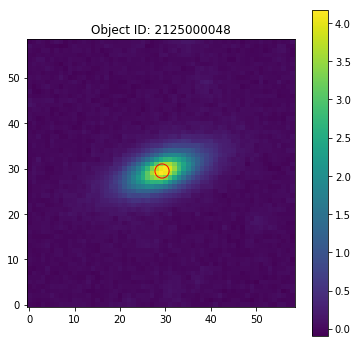

e1 true: -0.3974382607136181
e2 true: 0.32201890916956166
shear_1 true: -0.0
shear_2 true: 0.0
redshift true: 0.02128626011376622


In [21]:
# Plot just one
i = 1
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)
cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

590497 1391


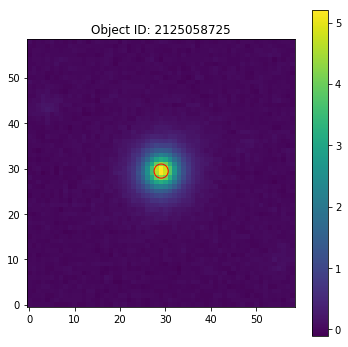

e1 true: 0.014222186293827424
e2 true: 0.029041346752897348
shear_1 true: -0.0006269724673763077
shear_2 true: -0.0002656519126478623
redshift true: 0.2559607785823692


In [22]:
# Plot just one
i = 900
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)
cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

520632 0


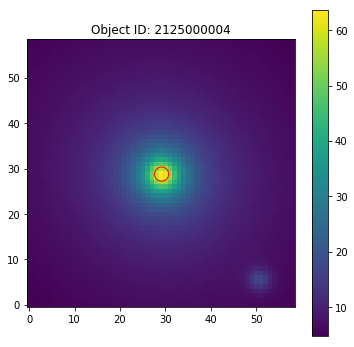

e1 true: -0.020480165393170054
e2 true: -0.05912438897085703
shear_1 true: -0.0
shear_2 true: 0.0
redshift true: 0.010269957322831536


In [23]:
# Plot just one
i = 0
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)
cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

## Check that object and truth data are indeed matched correclty

### Check part of the sky

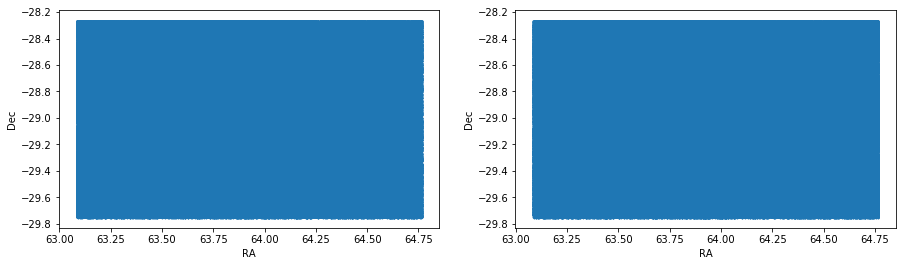

In [24]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
axes[0].scatter(object_data['ra'], object_data['dec'], s=1, rasterized=True);
axes[1].scatter(truth_data['ra'], truth_data['dec'], s=1, rasterized=True);

axes[0].set_xlabel('RA');
axes[0].set_ylabel('Dec');

axes[1].set_xlabel('RA');
axes[1].set_ylabel('Dec');

### Check magnitudes

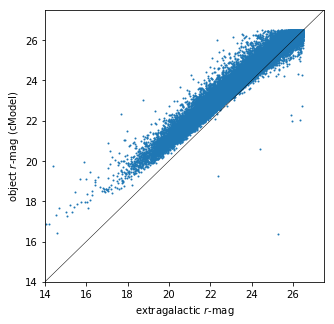

In [25]:
plt.figure(figsize=(5,5));
plt.scatter(truth_data['mag_r'][truth_idx[:100000]], object_data['mag_r'][object_idx[:100000]], s=1);
lims = [14, 27.5]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic $r$-mag');
plt.ylabel('object $r$-mag (cModel)');
plt.xlim(lims);
plt.ylim(lims);

### Why is this off ??? 

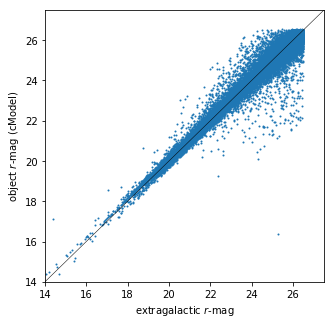

In [26]:
plt.figure(figsize=(5,5));
plt.scatter(truth_data['mag_r_lsst'][truth_idx[:100000]], object_data['mag_r_cModel'][object_idx[:100000]], s=1);
lims = [14, 27.5]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic $r$-mag');
plt.ylabel('object $r$-mag (cModel)');
plt.xlim(lims);
plt.ylim(lims);

### Check total ellipticities

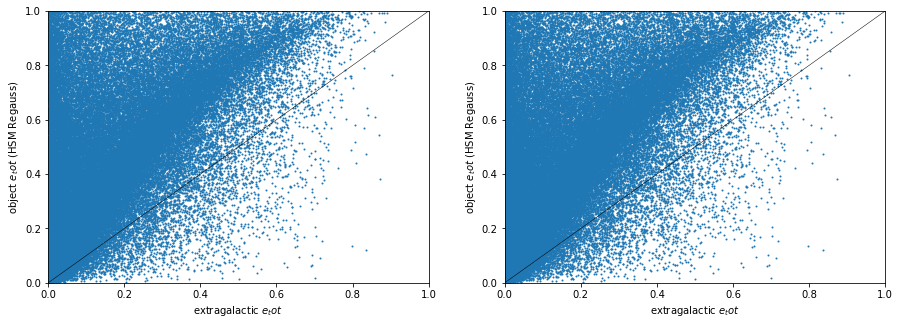

In [27]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
ellipticity_obs= np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'], object_data['ext_shapeHSM_HsmShapeRegauss_e2'])
axes[0].scatter(truth_data['ellipticity_true'][truth_idx[:100000]], ellipticity_obs[object_idx[:100000]], s=1);
lims = [0, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_tot$');
axes[0].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


ellipticity_truth = np.hypot(truth_data['ellipticity_1_true'],truth_data['ellipticity_2_true'])
axes[1].scatter(ellipticity_truth[truth_idx[:100000]], ellipticity_obs[object_idx[:100000]], s=1);
lims = [0, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_tot$');
axes[1].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

The ellipticity comparison plot above is quite surprising. 
It seems that the ellipticities in the object catalog are generally higher (i.e., less round) than those in the extragalactic catalog. 

The quantity `shape_hsm_regauss_etot` that we used for the object catalog are the re-Gaussianization shapes, which are PSF corrected, and they could be either rounder (if the correction was an under-correction) or less round (if the correction was an over-correction). Hence, their value being systematically larger than the "truth" from extragalactic catalog seems problematic. 

Before we panic, we should, however, remind ourselves of the definition of ellipticities used in these catalogs. 
For the extragalactic catalog, ellipticity is defined as $(1-q)/(1+q)$, where $q$ is the minor-to-major axis ratio
(see the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)). 
On the other hand, for the object catalog, the HSM re-Gaussianization ellipticity that we are using is defined as $(1-q^2)/(1+q^2)$
(see e.g., Eq. 8 of [Mandelbaum et al. 2006](https://arxiv.org/abs/astro-ph/0511164)).

Hence their definitions are in fact different, so we need to do a conversion before we compare them.
With some math, we can find the conversion between the two definitions $e_{\rm HSM~def} = \frac{2e_{\rm EGC~def}}{1+e_{\rm EGC~def}^2}$.

In [28]:
ellipticity_conversion = lambda e: 2*e / (1.0+e*e)

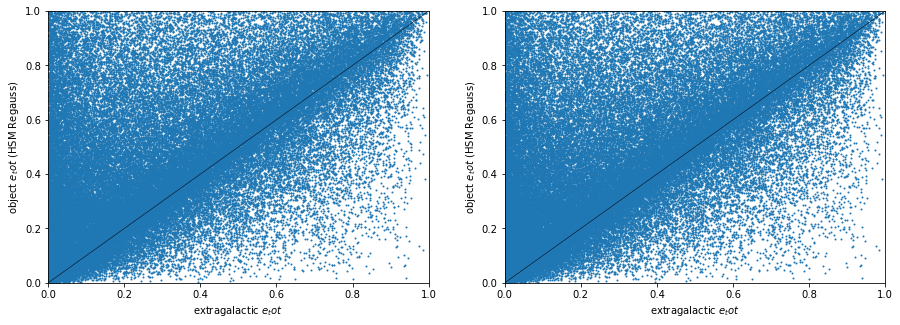

In [29]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
ellipticity_obs= np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'], object_data['ext_shapeHSM_HsmShapeRegauss_e2'])
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_true'][truth_idx[:100000]]), ellipticity_obs[object_idx[:100000]], s=1);
lims = [0, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_tot$');
axes[0].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


ellipticity_truth = np.hypot(truth_data['ellipticity_1_true'],truth_data['ellipticity_2_true'])
axes[1].scatter(ellipticity_conversion(ellipticity_truth[truth_idx[:100000]]), ellipticity_obs[object_idx[:100000]], s=1);
lims = [0, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_tot$');
axes[1].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

This looks much better now! 

When you were checking the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)) file,
you probably have also noticed that `ellipticity_true` is the ellipticity before the shear is applied (i.e., unlensed). 
Hence this comparison is still not an apples-to-apples comparison, as the ellipticity in the object catalog is, of course, lensed. 

According to the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)), we should have been using `ellipticity` from the extragalactic catalog.
But unfortunately, this quantity is not directly available from the extragalactic catalog!

In [30]:
def calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =  es1 + es2*1j # intrinsic ellipticity (as a complex number)#
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.absolute(e)


In [31]:
    
gc.add_derived_quantity('ellipticity', calc_lensed_ellipticity, 
                                       'ellipticity_1_true', 'ellipticity_2_true', 'shear_1', 'shear_2', 'convergence')

In [32]:
quantities = ['galaxy_id', 'ra', 'dec', 
              'mag_r', 'mag_r_lsst',
              'redshift',
              'ellipticity_true', 'ellipticity',
              'ellipticity_1_true', 'ellipticity_2_true',
              'shear_1', 'shear_2']
truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

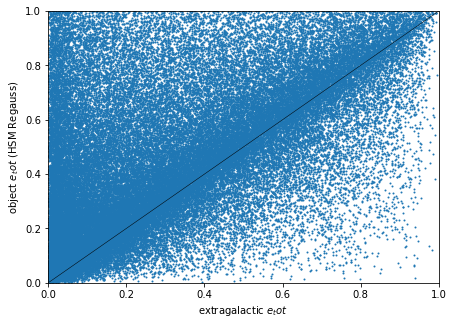

In [33]:
plt.figure(figsize=(7,5));
ellipticity_obs= np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'], object_data['ext_shapeHSM_HsmShapeRegauss_e2'])
plt.scatter(ellipticity_conversion(truth_data['ellipticity'][truth_idx[:100000]]), ellipticity_obs[object_idx[:100000]], s=1);
lims = [0, 1]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic $e_tot$');
plt.ylabel('object $e_tot$ (HSM Regauss)');
plt.xlim(lims);
plt.ylim(lims);

### Check $e_1$ and $e_2$

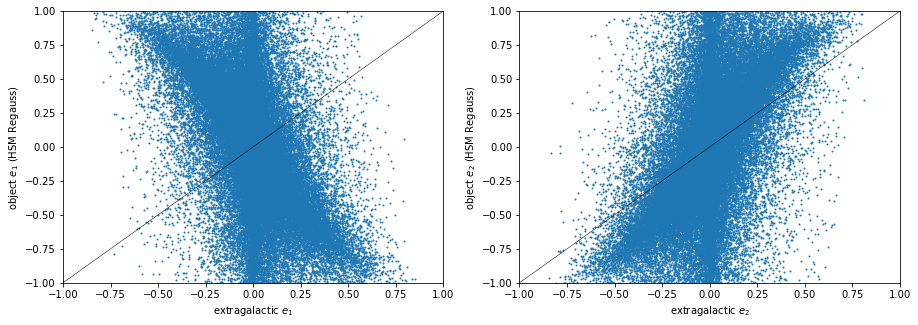

In [34]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(truth_data['ellipticity_1_true'][truth_idx[:100000]], object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(truth_data['ellipticity_2_true'][truth_idx[:100000]], object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

Now let's correct for $e_1$ and $e_2$

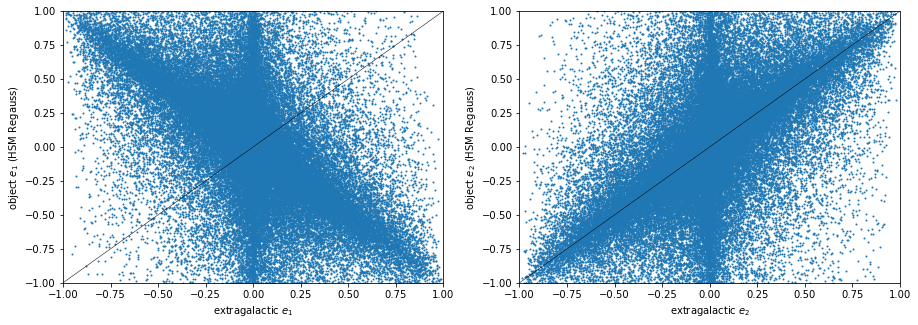

In [35]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_1_true'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

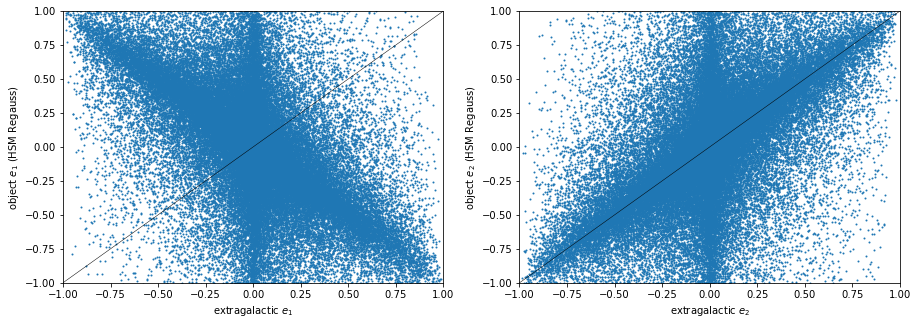

In [36]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_1_true'][truth_idx[:100000]]+truth_data['shear_1'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]]+truth_data['shear_2'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

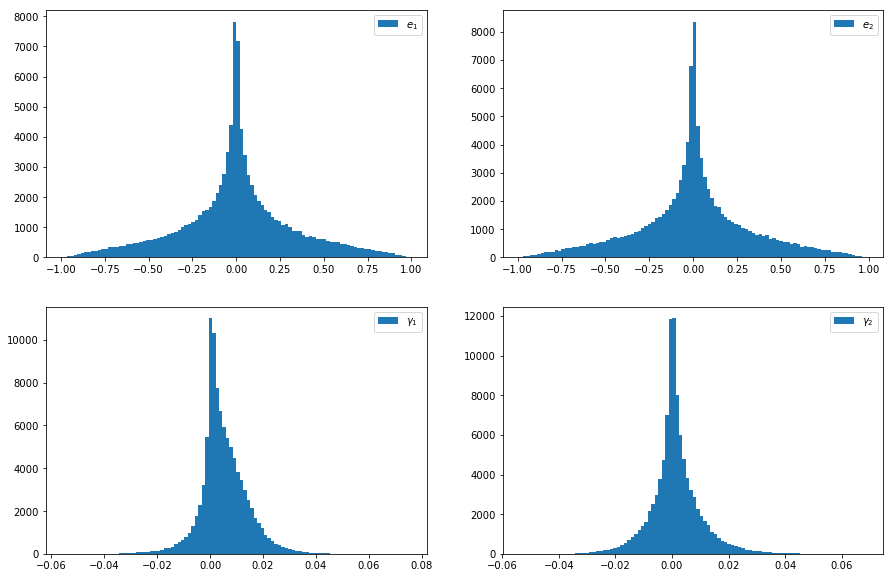

In [37]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
_ = axes[0,0].hist(ellipticity_conversion(truth_data['ellipticity_1_true'][truth_idx[:100000]]), bins = 100, label = '$e_1$')
_ = axes[0,1].hist(ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]]), bins = 100, label = '$e_2$')
_ = axes[1,0].hist(ellipticity_conversion(truth_data['shear_1'][truth_idx[:100000]]), bins = 100, label = '$\gamma_1$')
_ = axes[1,1].hist(ellipticity_conversion(truth_data['shear_2'][truth_idx[:100000]]), bins = 100, label = '$\gamma_2$')

axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()

Applying the same transofmration including convergence as for total ellipticity

In [38]:
def calc_lensed_ellipticity_1(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =  es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.real(e)

def calc_lensed_ellipticity_2(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =   es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.imag(e)

In [39]:
gc.add_derived_quantity('ellipticity_1', calc_lensed_ellipticity_1, 
                                       'ellipticity_1_true', 'ellipticity_2_true', 'shear_1', 'shear_2', 'convergence')

gc.add_derived_quantity('ellipticity_2', calc_lensed_ellipticity_2, 
                                       'ellipticity_1_true', 'ellipticity_2_true', 'shear_1', 'shear_2', 'convergence')

In [40]:
quantities = ['galaxy_id', 'ra', 'dec', 
              'mag_r', 'mag_r_lsst',
              'redshift',
              'ellipticity_true', 'convergence',
              'ellipticity_1_true', 'ellipticity_2_true',
              'ellipticity_1', 'ellipticity_2',
              'shear_1', 'shear_2']
truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

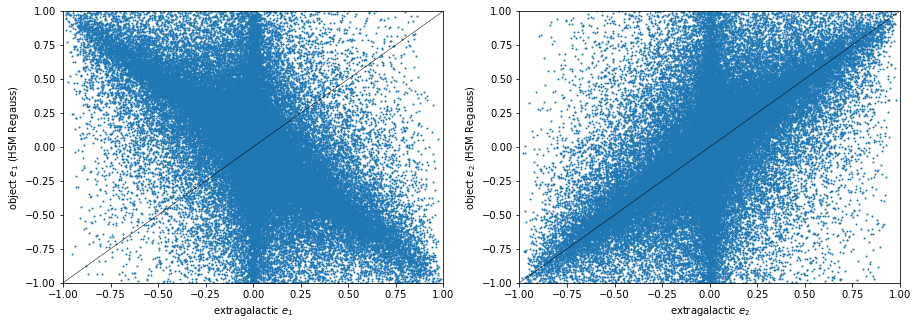

In [41]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_1'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

Weird, it seems that the true $e_1$ has a sign inversion (confirmed on images).

<img src="imgs/shear_transformation.png" alt="Drawing" style="width: 400px;"/>

If I change the sign:

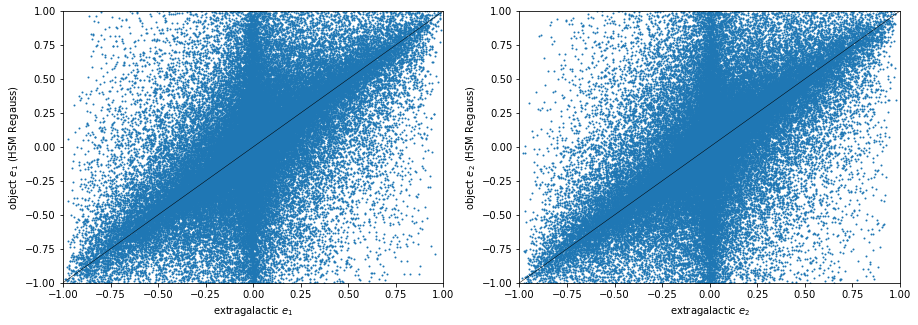

In [42]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(ellipticity_conversion(-truth_data['ellipticity_1'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

Check if ellipticity measurment other than ReGauss exists: No

In [43]:
print('\n'.join(sorted(gc_obs.list_all_quantities(include_native=True))))

I_flag
I_flag_g
I_flag_i
I_flag_r
I_flag_u
I_flag_y
I_flag_z
Ixx
IxxPSF
IxxPSF_g
IxxPSF_i
IxxPSF_r
IxxPSF_u
IxxPSF_y
IxxPSF_z
Ixx_g
Ixx_i
Ixx_r
Ixx_u
Ixx_y
Ixx_z
Ixy
IxyPSF
IxyPSF_g
IxyPSF_i
IxyPSF_r
IxyPSF_u
IxyPSF_y
IxyPSF_z
Ixy_g
Ixy_i
Ixy_r
Ixy_u
Ixy_y
Ixy_z
Iyy
IyyPSF
IyyPSF_g
IyyPSF_i
IyyPSF_r
IyyPSF_u
IyyPSF_y
IyyPSF_z
Iyy_g
Iyy_i
Iyy_r
Iyy_u
Iyy_y
Iyy_z
base_Blendedness_abs
base_Blendedness_abs_child_instFlux
base_Blendedness_abs_child_xx
base_Blendedness_abs_child_xy
base_Blendedness_abs_child_yy
base_Blendedness_abs_parent_instFlux
base_Blendedness_abs_parent_xx
base_Blendedness_abs_parent_xy
base_Blendedness_abs_parent_yy
base_Blendedness_flag
base_Blendedness_flag_noCentroid
base_Blendedness_flag_noShape
base_Blendedness_old
base_Blendedness_raw
base_Blendedness_raw_child_instFlux
base_Blendedness_raw_child_xx
base_Blendedness_raw_child_xy
base_Blendedness_raw_child_yy
base_Blendedness_raw_parent_instFlux
base_Blendedness_raw_parent_xx
base_Blendedness_raw_parent_xy
base_Bl

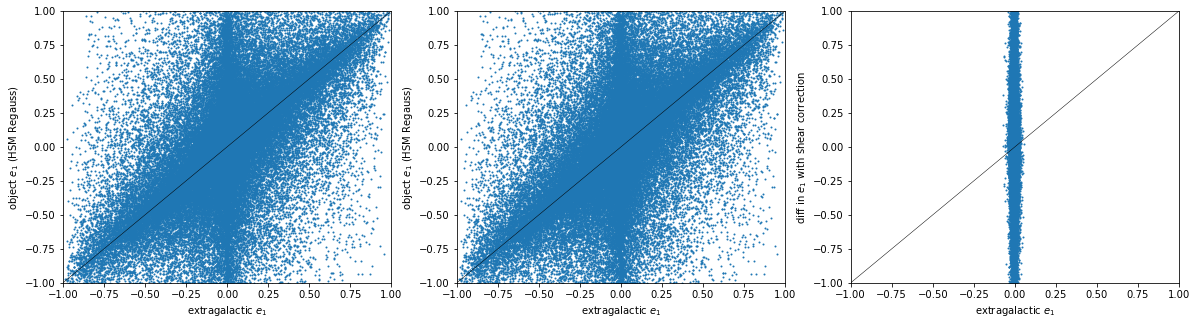

In [44]:
fig, axes = plt.subplots(1,3, figsize=(20,5));
axes[0].scatter(ellipticity_conversion(-truth_data['ellipticity_1_true'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);

axes[1].scatter(ellipticity_conversion(-truth_data['ellipticity_1'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_1$');
axes[1].set_ylabel('object $e_1$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

diff_1 = ellipticity_conversion(-truth_data['ellipticity_1'][truth_idx[:100000]]) - ellipticity_conversion(-truth_data['ellipticity_1_true'][truth_idx[:100000]])
axes[2].scatter(diff_1, object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[2].plot(lims, lims, c='k', lw=0.5);
axes[2].set_xlabel('extragalactic $e_1$');
axes[2].set_ylabel('diff in $e_1$ with shear correction');
axes[2].set_xlim(lims);
axes[2].set_ylim(lims);



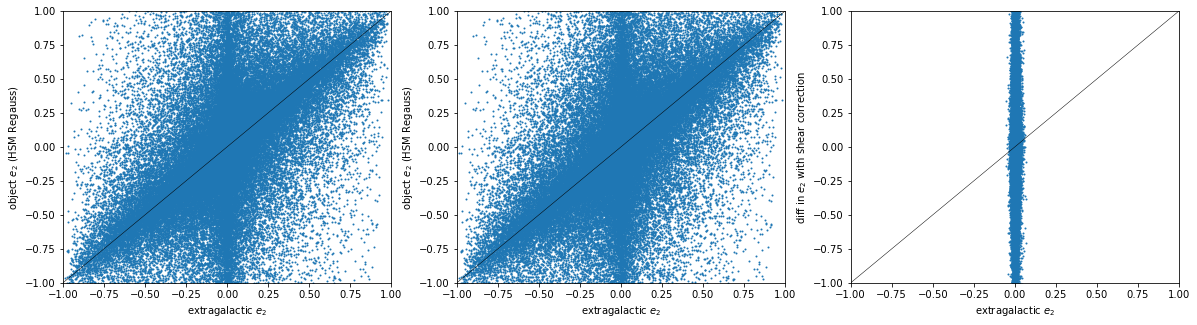

In [45]:
fig, axes = plt.subplots(1,3, figsize=(20,5));
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_2$');
axes[0].set_ylabel('object $e_2$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);

axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

diff_2 = ellipticity_conversion(truth_data['ellipticity_2'][truth_idx[:100000]]) - ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]])
axes[2].scatter(diff_2, object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1);
lims = [-1, 1]
axes[2].plot(lims, lims, c='k', lw=0.5);
axes[2].set_xlabel('extragalactic $e_2$');
axes[2].set_ylabel('diff in $e_2$ with shear correction');
axes[2].set_xlim(lims);
axes[2].set_ylim(lims);



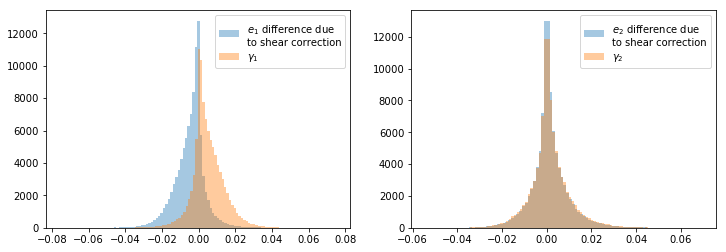

In [46]:
fig, axes = plt.subplots(1,2,figsize = (12,4))

_ = axes[0].hist(diff_1,  bins = 100, label = '$e_1$ difference due \nto shear correction', alpha = 0.4)
_ = axes[0].hist(ellipticity_conversion(truth_data['shear_1'][truth_idx[:100000]]), bins = 100, label = '$\gamma_1$', alpha = 0.4)
axes[0].legend()

_ = axes[1].hist(diff_2,  bins = 100, label = '$e_2$ difference due \nto shear correction', alpha = 0.4)
_ = axes[1].hist(ellipticity_conversion(truth_data['shear_2'][truth_idx[:100000]]), bins = 100, label = '$\gamma_2$', alpha = 0.4)
axes[1].legend()

Same sign problem for $\gamma_1$ than for $e_1$

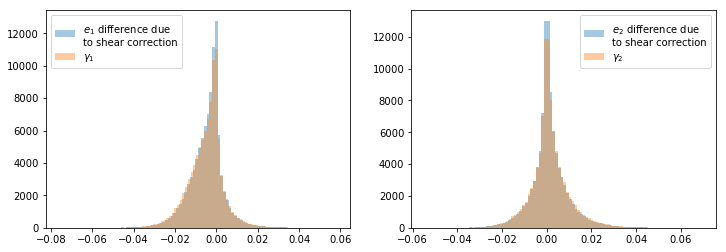

In [47]:
fig, axes = plt.subplots(1,2,figsize = (12,4))

_ = axes[0].hist(diff_1,  bins = 100, label = '$e_1$ difference due \nto shear correction', alpha = 0.4)
_ = axes[0].hist(ellipticity_conversion(-truth_data['shear_1'][truth_idx[:100000]]), bins = 100, label = '$\gamma_1$', alpha = 0.4)
axes[0].legend()

_ = axes[1].hist(diff_2,  bins = 100, label = '$e_2$ difference due \nto shear correction', alpha = 0.4)
_ = axes[1].hist(ellipticity_conversion(truth_data['shear_2'][truth_idx[:100000]]), bins = 100, label = '$\gamma_2$', alpha = 0.4)
axes[1].legend()

The impact of the convergence on the $e_1$ and $e_2$ is very low. We can only add the shear $\gamma_1$ and $\gamma_2$ of each part of the ellipticity $(e_1,e_2)$ as first estimation of the shear impact.

### Check other distributions

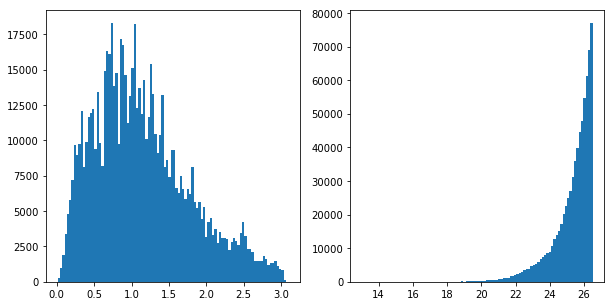

In [48]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
_ = axes[0].hist(truth_data['redshift'], bins = 100)
_ = axes[1].hist(truth_data['mag_r'], bins = 100)

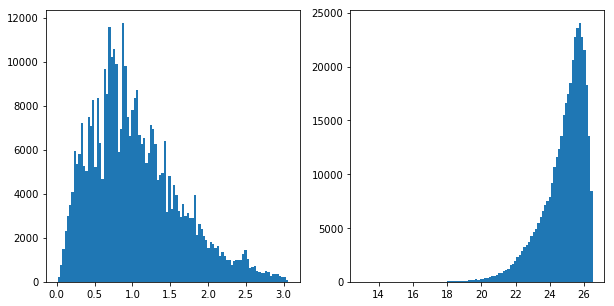

In [49]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
_ = axes[0].hist(truth_data['redshift'][truth_idx], bins = 100)
_ = axes[1].hist(truth_data['mag_r'][truth_idx], bins = 100)

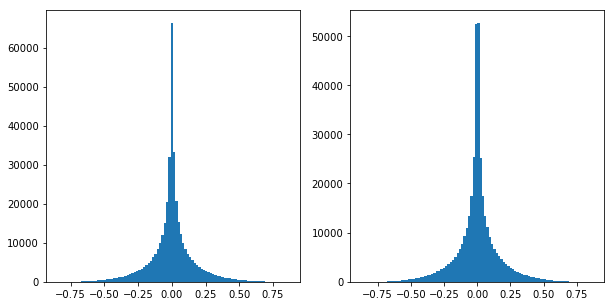

In [50]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
_ = axes[0].hist(truth_data['ellipticity_1_true'][truth_idx], bins = 100)
_ = axes[1].hist(truth_data['ellipticity_2_true'][truth_idx], bins = 100)

Text(0, 0.5, '$r$-magnitude')

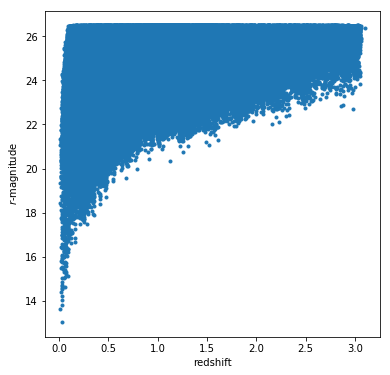

In [51]:
plt.plot(truth_data['redshift'], truth_data['mag_r'], '.')
plt.xlabel('redshift')
plt.ylabel('$r$-magnitude')

### Check img + ellipse fitted with ellipticity true values

As a function of the sign of $e_1$, width and height are inverted.

596168 13


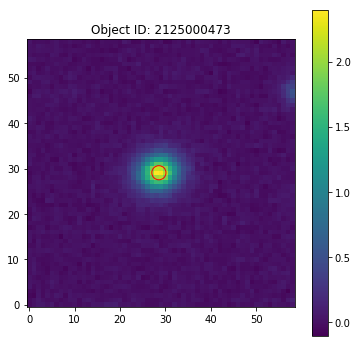

In [52]:
# Plot just one
i = 10
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: -0.09969687239698169
e2 true: 0.05080216661964432
shear_1 true: -1.3997631268414246e-05
shear_2 true: 4.231821281933749e-05
redshift true: 0.03861878519130468
13.50092911456568 0.49868190794939565


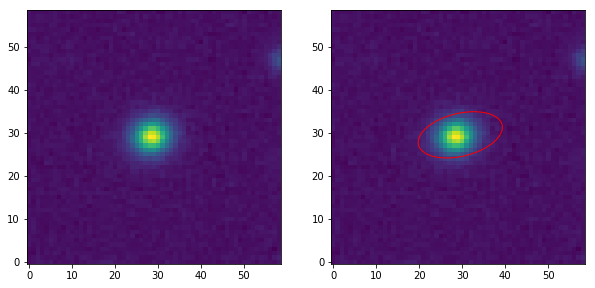

In [53]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')
#ax[0].colorbar()

phi = np.arctan(truth_data['ellipticity_2_true'][truth_idx[i]]/-truth_data['ellipticity_1_true'][truth_idx[i]])/2
hypot = np.hypot(truth_data['ellipticity_1_true'][truth_idx[i]], truth_data['ellipticity_2_true'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))
print(phi*180/np.pi, q)
width = 20
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

520648 20


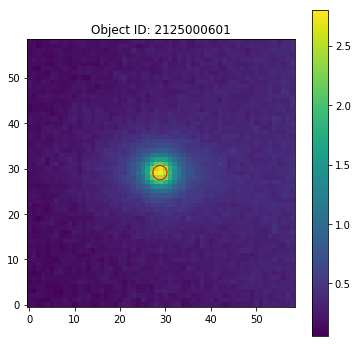

In [54]:
# Plot just one
i = 17
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: -0.17854626126747486
e2 true: -0.03397228528432375
shear_1 true: -1.4186877369870565e-05
shear_2 true: 0.00022897177458736106
redshift true: 0.07107975244389064


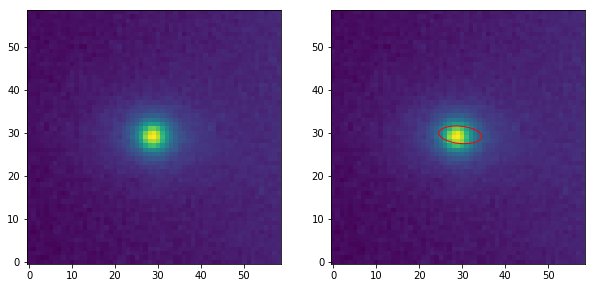

In [55]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(truth_data['ellipticity_2_true'][truth_idx[i]]/-truth_data['ellipticity_1_true'][truth_idx[i]])/2
hypot = np.hypot(-truth_data['ellipticity_1_true'][truth_idx[i]], truth_data['ellipticity_2_true'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 10
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

516229 18


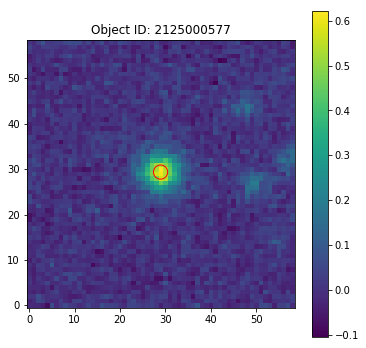

In [56]:
# Plot just one
i = 15
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: 0.011451132336940874
e2 true: -0.044219824223313275
shear_1 true: 9.8891019975067e-06
shear_2 true: 5.756351322363474e-05
redshift true: 0.04623058643327749
37.74082648022916 0.6478194751980006


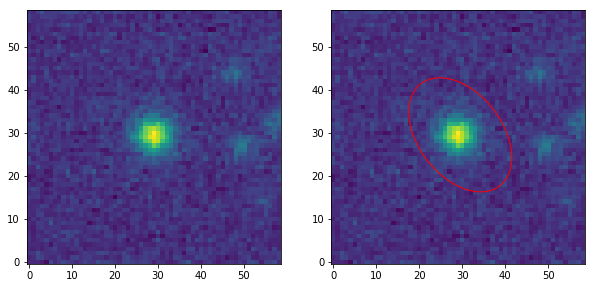

In [57]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(truth_data['ellipticity_2_true'][truth_idx[i]]/-truth_data['ellipticity_1_true'][truth_idx[i]])/2
hypot = np.hypot(truth_data['ellipticity_1_true'][truth_idx[i]], truth_data['ellipticity_2_true'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

print(phi*180/np.pi, q)
width = 30
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

Ellipse is completly off for true value. What about with corrected values ? 

e1 true: 0.011451132336940874
e2 true: -0.044219824223313275
shear_1 true: 9.8891019975067e-06
shear_2 true: 5.756351322363474e-05
redshift true: 0.04623058643327749
e1 obs: 0.011461097632624338
e2 obs: -0.04416235615754602


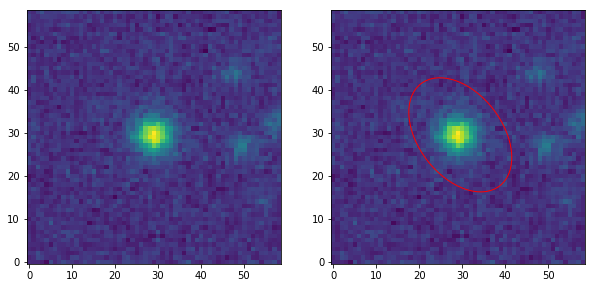

In [58]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

print('e1 obs: '+str(truth_data['ellipticity_1'][truth_idx[i]]))
print('e2 obs: '+str(truth_data['ellipticity_2'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(truth_data['ellipticity_2'][truth_idx[i]]/-truth_data['ellipticity_1'][truth_idx[i]])/2
hypot = np.hypot(-truth_data['ellipticity_1'][truth_idx[i]], truth_data['ellipticity_2'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 30
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

 And with observed values ? 

e1 true: 0.011451132336940874
e2 true: -0.044219824223313275
shear_1 true: 9.8891019975067e-06
shear_2 true: 5.756351322363474e-05
redshift true: 0.04623058643327749
e1 obs: -0.07054141163825989
e2 obs: -0.12767744064331055


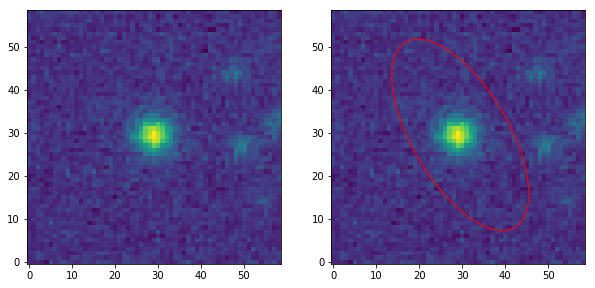

In [59]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

print('e1 obs: '+str(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]]))
print('e2 obs: '+str(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]]/object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]])/2
hypot = np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]], object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 50

if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

# Add PSF image

## Generate PSF images

The cutout image object retains full information from the image, including the PSF model.

The PSF model is accessible as a function object that can be evaluated a specific locations.

In addition, the coadd catalog saves the xx, xy, yy moments of the PSF model at the location of photometered objects.

In [60]:
# We still have our cutout image object from above
psf = cutout.getPsf()

In [61]:
print(psf)

In [62]:
help(psf)

Help on CoaddPsf in module lsst.meas.algorithms.coaddPsf.coaddPsf object:

class CoaddPsf(PersistableFacadeCoaddPsf, lsst.meas.algorithms.imagePsf.ImagePsf)
 |  Method resolution order:
 |      CoaddPsf
 |      PersistableFacadeCoaddPsf
 |      lsst.meas.algorithms.imagePsf.ImagePsf
 |      lsst.meas.algorithms.imagePsf.PersistableFacadeImagePsf
 |      lsst.afw.detection.Psf
 |      lsst.afw.typehandling.Storable
 |      lsst.afw.table.io.Persistable
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.meas.algorithms.coaddPsf.coaddPsf.CoaddPsf, catalog: lsst.afw.table.ExposureCatalog, coaddWcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs, weightFieldName: str='weight', warpingKernelName: str='lanczos3', cacheSize: int=10000) -> None
 |      
 |      2. __init__(self: lsst.meas.algorithms.coaddPsf.coaddPsf.CoaddPsf, catalog: l

The repetition in the object name is a consequence of the pybind11 mapping.  It's really a `lsst.meas.algorithms.coaddPsf.CoaddPsf` object.  The C++ documentation unfortunately doesn't come through nicely through the wrapping to Python:

We can look up the documentation in the LSST DM Stack Doxygen pages.  If we assume (correctly for these purposes) that a CoaddPsf is just like a regular PSF, then we can look here:
http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1detection_1_1_psf.html

where we will see that there are several relevant functions:
`computeImage`: Return an Image of the PSF, in a form that can be compared directly with star images.
`computeKernelImage`:  Return an Image of the PSF, in a form suitable for convolution.
`computeShape`: Compute the ellipse corresponding to the second moments of the Psf.

and then some interesting things you might not have expected to even be available:
`getAverageColor`: Return the average Color of the stars used to construct the Psf.
`getAveragePosition`: Return the average position of the stars used to construct the Psf. 

Unfortunately, the documentation is hard to read from a Python perspective.  What kind of arguments does the following function actually want and how do I create those objects?

computeImage(...) from builtins.PyCapsule
        computeImage(self: lsst.afw.detection._psf.Psf, position: lsst.afw.geom.coordinates.coordinates.Point2D=Point2D(nan, nan), color: lsst.afw.image.color.Color=<lsst.afw.image.color.Color object at 0x2b8f57b38928>, owner: lsst.afw.detection._psf.ImageOwnerEnum=ImageOwnerEnum.COPY) -> lsst.afw.image.image.image.ImageD)

Examples are easiest:

In [63]:
# Let's use the same first row to get an RA, Dec and translate that to an x, y on the image plane.
i = 15
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

kernel_image = psf.computeImage(xy)

516229 18


In [64]:
psf.computeImage(xy).getDimensions

<bound method PyCapsule.getDimensions of lsst.afw.image.image.image.ImageD=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], bbox=(minimum=(22053, 23822), maximum=(22111, 23880))>

In [65]:
psf.computeImage(xy).getDimensions()

Extent2I(59, 59)

In [66]:
psf.computeImage(xy).getX0()

22053

The object we get back is an `lsst.afw.image.image.ImageD` -- An `Image` in double precision.

Let's display the kernel image we made:

In [67]:
help(psf.computeImage)

Help on method computeImage in module lsst.afw.detection:

computeImage(...) method of lsst.meas.algorithms.coaddPsf.coaddPsf.CoaddPsf instance
    computeImage(self: lsst.afw.detection.Psf, position: lsst.geom.Point2D=Point2D(nan, nan), color: lsst.afw.image.color.Color=<lsst.afw.image.color.Color object at 0x7fb43fb1b470>, owner: lsst.afw.detection.Psf.ImageOwnerEnum=ImageOwnerEnum.???) -> lsst.afw.image.image.image.ImageD



In [68]:
kernel_image

lsst.afw.image.image.image.ImageD=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], bbox=(minimum=(22053, 23822), maximum=(22111, 23880))

In [69]:
help(kernel_image)

Help on ImageD in module lsst.afw.image.image.image object:

class ImageD(ImageBaseD)
 |  Method resolution order:
 |      ImageD
 |      ImageBaseD
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other)
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __iadd__(...)
 |      __iadd__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __iadd__(self: lsst.afw.image.image.image.ImageD, arg0: float) -> lsst.afw.imag

For comparison, the postage stamp is a full `lsst.afw.image.exposure.ExposureF`.  An `Exposure` contains a `MaskedImage` (an image, a mask, and variance plane), along with an optional SkyWCS.
http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1image_1_1_exposure.html#details

An `Exposure` can also generate `subExposures`, which are `Exposure`s of a subset of the pixels.  Our postage stamp cutout is thus an `Exposure`.  The additional information is what allowed `afwDisplay` to show the image with the original pixel coordinates.

If you read a `raw`, `calexp`, or `deepCoadd` or similar image product through the Butler, you will get an `Exposure`.

In [70]:
help(cutout)

Help on ExposureF in module lsst.afw.image.exposure.exposure object:

class ExposureF(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      ExposureF
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other)
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, w

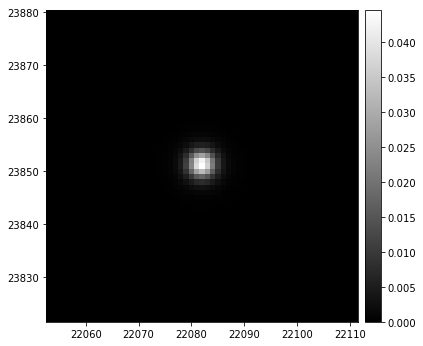

In [71]:
frame = 2
plt.figure(frame)
display = afwDisplay.Display(frame=frame, backend='matplotlib')
display.scale("linear", "minmax")
display.mtv(kernel_image)

(59, 59)

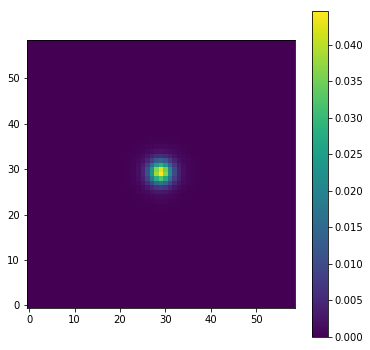

In [72]:
plt.imshow(kernel_image.array, origin = 'lower')
plt.colorbar()

kernel_image.array.shape

Above we see an image of the PSF centered at the x, y position corresponding to the RA, Dec position of the object.  This is a convenient representation to use to subtract.

Note that while the cutout was 51x51 pixels (the default `cutoutSideLength` in `cutout_coadd_spherepoint` above), the PSF is 61x61 pixels.  That's the default size of specifying the full PSF. You can actually have a 64x64 pixels cutout image modifying the `cutoutSideLength` in the `cutout_coadd_spherepoint` function

Try then to generate a PSF image suitable for convolution:

In [73]:
kernel_image_conv = psf.computeKernelImage(xy)

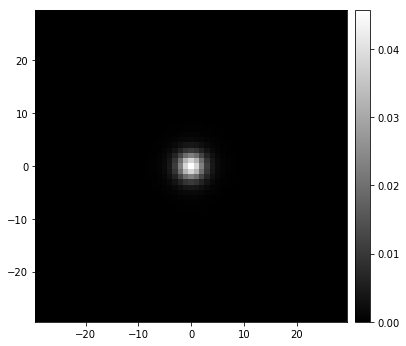

In [74]:
frame = 2
plt.figure(frame)
display = afwDisplay.Display(frame=frame, backend='matplotlib')
display.scale("linear", "minmax")
display.mtv(kernel_image_conv)

(59, 59)

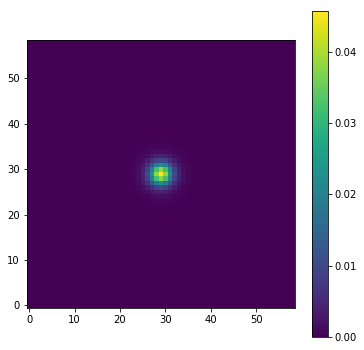

In [75]:
plt.imshow(kernel_image_conv.array, origin = 'lower')
plt.colorbar()

kernel_image_conv.array.shape

## Try rescaling PSF image to match cutout size (fixed at 64x64)

Is it possible to have a 64x64 image of the PSF ? Can't find the answer in the `help(psf)` so I can use the method describe in the `dm_butler_postage_stamps` notebook:

In [76]:
reload(cutout_img_dc2)

<module 'tools_for_VAE.cutout_img_dc2' from '../../scripts/tools_for_VAE/tools_for_VAE/cutout_img_dc2.py'>

Here try on 64x64 pixel image

516229 18


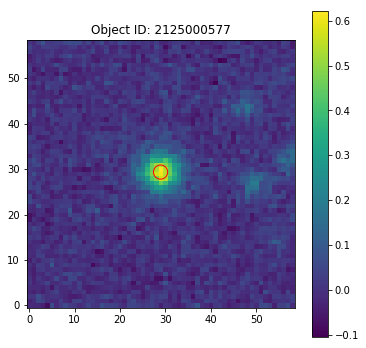

In [77]:
# Plot just one
i = 15
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

In [78]:
psf = cutout.getPsf()

# Let's use the same first row to get an RA, Dec and translate that to an x, y on the image plane.
i = 15
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

kernel_image_conv = psf.computeKernelImage(xy)

516229 18


In [79]:
np.size(kernel_image_conv.array)

3481

(59, 59)

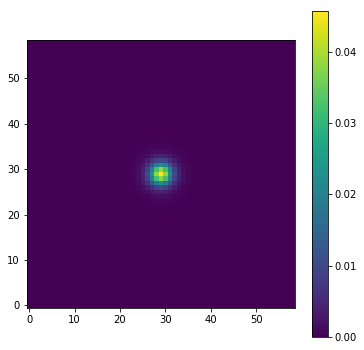

In [80]:
plt.imshow(kernel_image_conv.array, origin = 'lower')
plt.colorbar()

kernel_image_conv.array.shape

In [81]:
cutout_nx, cutout_ny = np.shape(cutout.image.array)
kernel_nx, kernel_ny = np.shape(kernel_image_conv.array)

cutout_slice = cutout.image.array[cutout_nx//2, :]
kernel_slice = kernel_image_conv.array[kernel_nx//2, :]

# Normalize PSF sum to cutout sum in this slice
scaling = np.sum(cutout_slice)/np.sum(kernel_slice)

# Assume that the PSF kernel size is *lower* than the cutout size.
offset_nx = cutout_nx - kernel_nx 
offset_ny = cutout_ny - kernel_ny 


In [82]:
cutout_slice.shape, kernel_slice.shape

((59,), (59,))

Subtract a scaled version of the PSF from the image array.
Note that we have to select out just the section of the PSF that's within the cutout.

In [83]:
cutout_minus_psf = kernel_image_conv.array - \
    scaling * cutout.image.array[offset_nx//2:-offset_nx//2,
                                 offset_ny//2:-offset_ny//2]

ValueError: operands could not be broadcast together with shapes (59,59) (0,0) 

In [ ]:
cutout_minus_psf.size, 59*59

In [ ]:
scaling

In [ ]:
cutout_minus_psf = cutout.image.array + \
    scaling * kernel_image_conv.array[offset_nx//2:-offset_nx//2,
                                 offset_ny//2:-offset_ny//2]

In [ ]:
array = kernel_image_conv.array.copy()
print(array.size)
array.resize((64,64))
print(array.size)
#plt.imshow(test_resize.astype(float32))

In [ ]:
plt.imshow(array.reshape(64,64))

To create an `Exposure` with the pixel values of subtracting the PSF model we create a copy of the postage stamp and set the image data array to the residual value we just calculated above.
We keep the WCS, the pixel mapping of this subExposure, and the mask and variance plane.

In [ ]:
residual = cutout.clone()
residual.setImage(afwImage.ImageF(afwImage.ImageF(cutout_minus_psf.astype(np.float32))))

frame = 4
plt.figure(frame)
display = afwDisplay.Display(frame=frame,backend='matplotlib')
display.scale("linear", "minmax")
display.mtv(cutout)

In [ ]:
plt.imshow(kernel_image_conv.array, origin = 'lower')
plt.colorbar()


kernel_image_conv.array.shape

## Fix the cutout image to the PSF image size so I don't have to worry about rescaling

In [84]:
reload(cutout_img_dc2)

<module 'tools_for_VAE.cutout_img_dc2' from '../../scripts/tools_for_VAE/tools_for_VAE/cutout_img_dc2.py'>

Go to 59x59 pixels size for stamps

519782 19


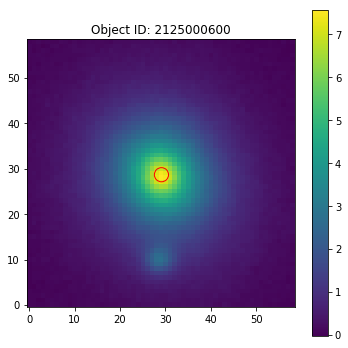

In [85]:
i = 16
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: 0.03590922526880659
e2 true: -0.050523586442690435
shear_1 true: -3.768900643141837e-05
shear_2 true: 0.00020382012379233588
redshift true: 0.07123882653582769


(59, 59)

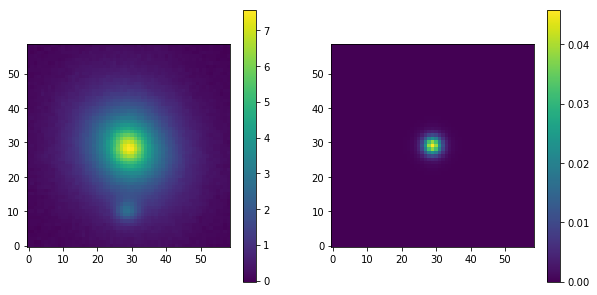

In [86]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

fig_1 = ax[0].imshow(img_array, origin='lower')

phi = np.arctan(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]]/object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]])/2
hypot = np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]], object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 50

if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((32,32), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((32,32), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

fig_2 = ax[1].imshow(kernel_image_conv.array, origin = 'lower')

fig.colorbar(fig_1 ,ax=ax[0])
fig.colorbar(fig_2 ,ax=ax[1])

kernel_image_conv.array.shape

# Generate multi-bands images of scenes and PSF

## Visualize different filters

Image in $r$ filter

519782 19


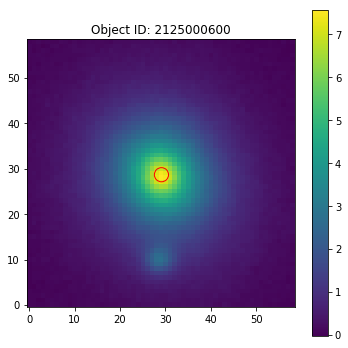

In [87]:
i = 16
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout_r = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Image in $i$ filter

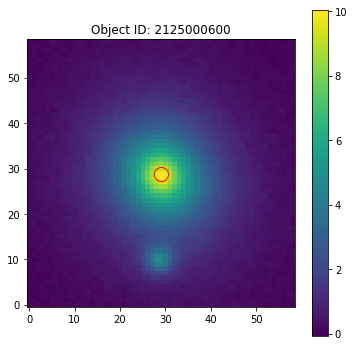

In [88]:
frame = 0
plt.figure(frame)

cutout_i = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='i', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Image in $z$ filter

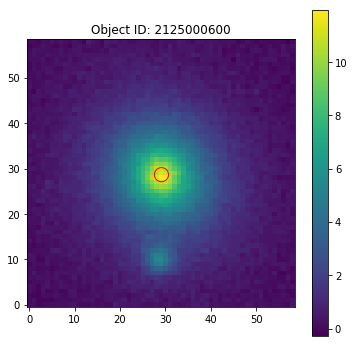

In [89]:
frame = 0
plt.figure(frame)

cutout_z = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='z', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Plot in rgb (here $r,i,z$)

In [91]:
# galaxies scene image
gal = np.zeros((3, 59,59))

gal[0] = cutout_r.image.array
gal[1] = cutout_i.image.array
gal[2] = cutout_z.image.array

# Normalize between [0,1] for display reasons only
gal -= np.min(gal)
gal /= np.max(gal)

# Necessary for PSF position
radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

# Create PSF image
psf_img = np.zeros((3, 59,59))
psf_img[0] = cutout_r.getPsf().computeKernelImage(xy).array
psf_img[1] = cutout_i.getPsf().computeKernelImage(xy).array
psf_img[2] = cutout_z.getPsf().computeKernelImage(xy).array

# Normalize between [0,1] for display reasons only
psf_img -= np.min(psf_img)
psf_img /= np.max(psf_img)

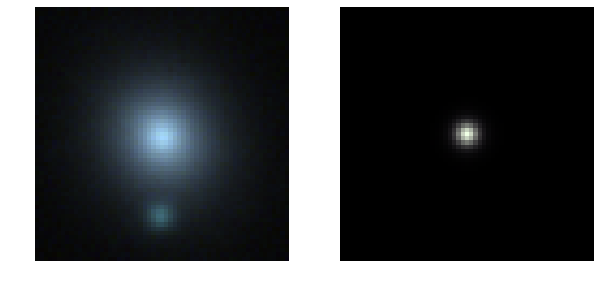

In [92]:
fig, axes  = plt.subplots(1,2, figsize = (10,5))

plot.plot_rgb(gal, bands=[0,1,2], ax=axes[0], band_first=True, zoom=1)
plot.plot_rgb(psf_img, bands=[0,1,2], ax=axes[1], band_first=True, zoom=1)

$u$ filter does not work as the butler is created from a catalog containing only $g,r,i,z,y$. To create the $u$ filter we will have to define a new butler

In [ ]:
frame = 0
plt.figure(frame)

cutout_u = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='u', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Defining the new butler:

In [93]:
repo = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-u'
butler_u = dafPersist.Butler(repo)

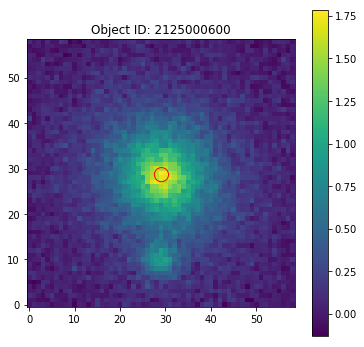

In [94]:
frame = 0
plt.figure(frame)

cutout_u = cutout_img_dc2.make_cutout_image(butler_u, ra, dec, filter='u', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

## Generate samples for networks

In [95]:
import time

In [96]:
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

e1 true: 0.03590922526880659
e2 true: -0.050523586442690435
shear_1 true: -3.768900643141837e-05
shear_2 true: 0.00020382012379233588
redshift true: 0.07123882653582769


0


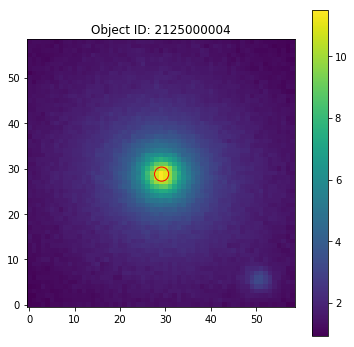

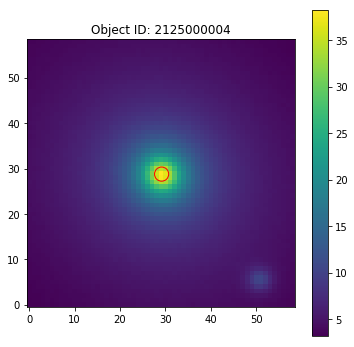

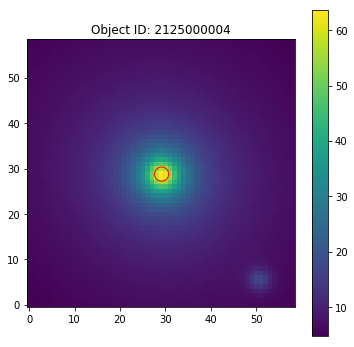

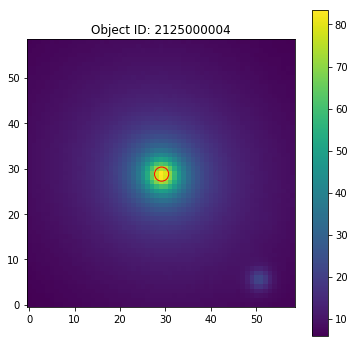

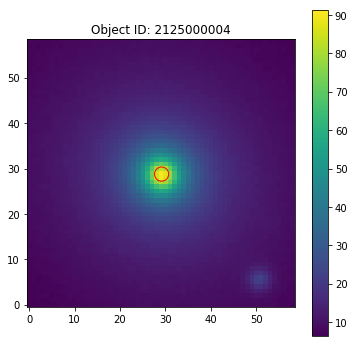

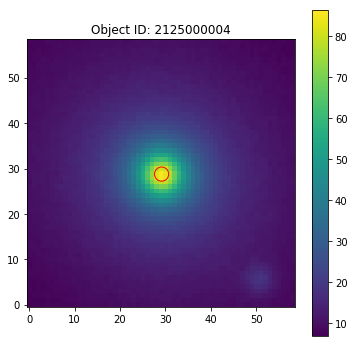

1


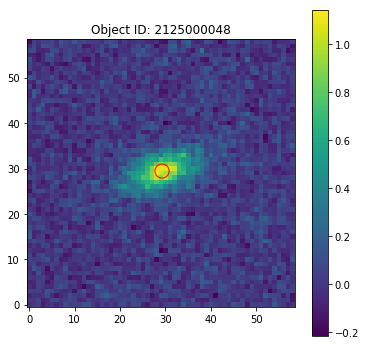

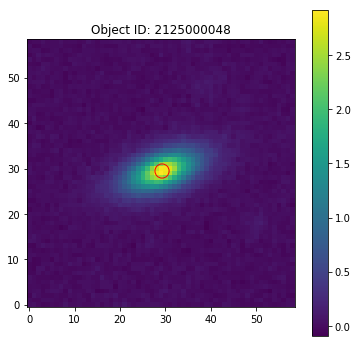

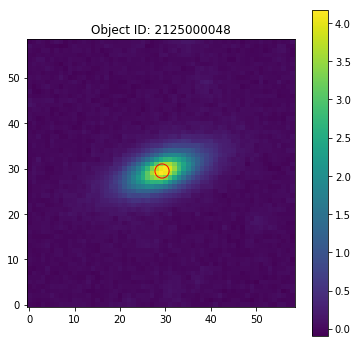

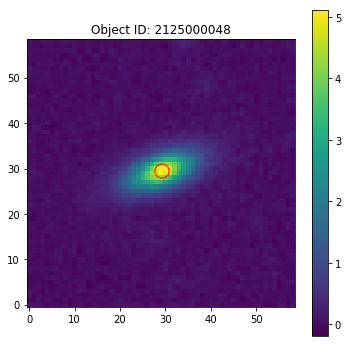

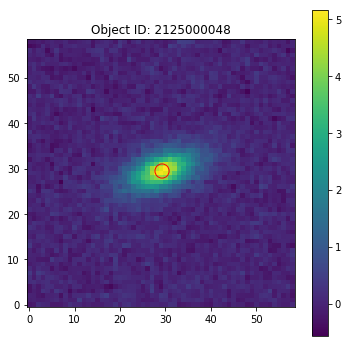

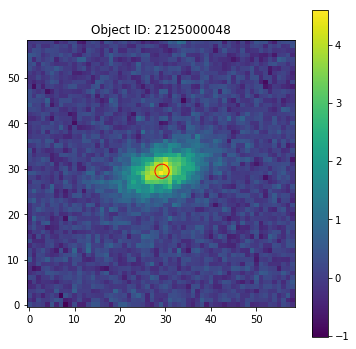

2


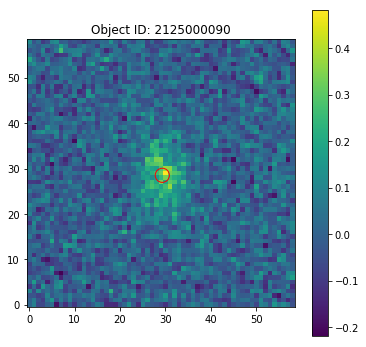

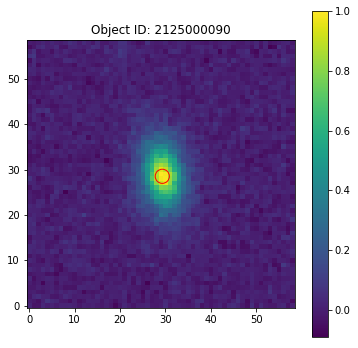

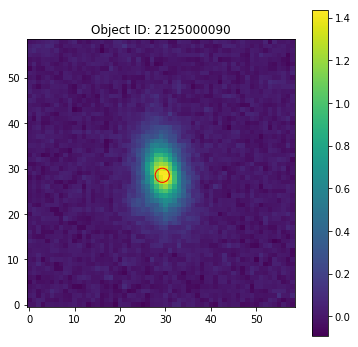

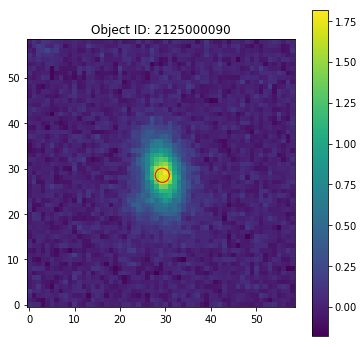

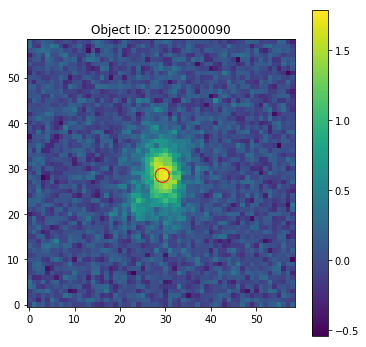

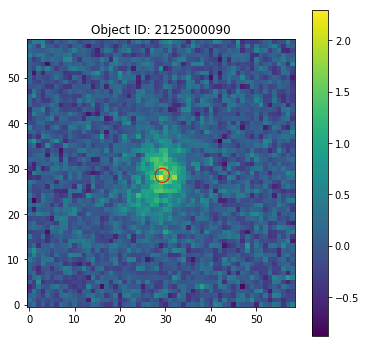

3


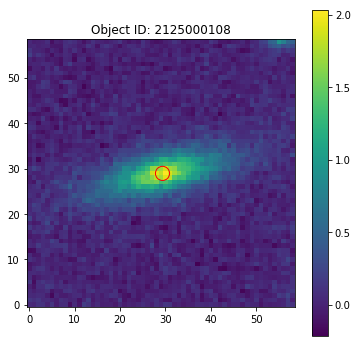

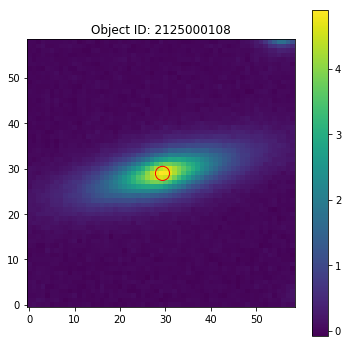

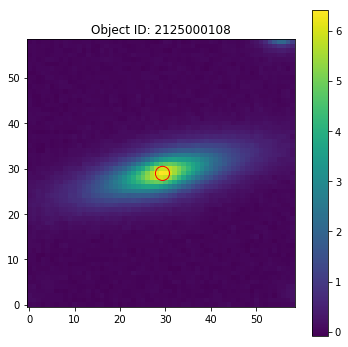

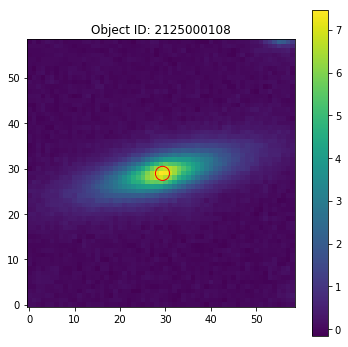

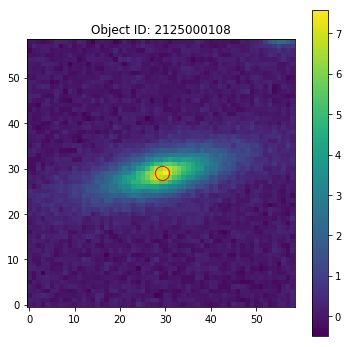

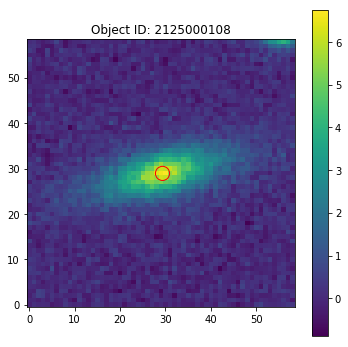

4


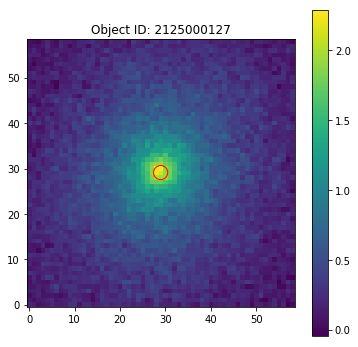

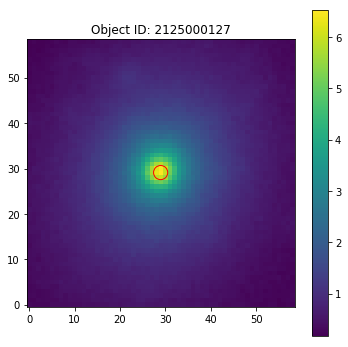

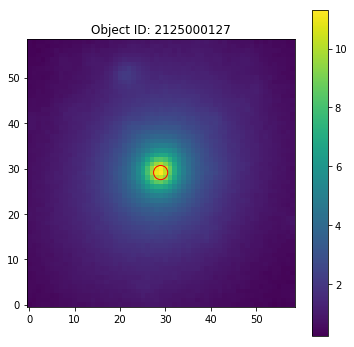

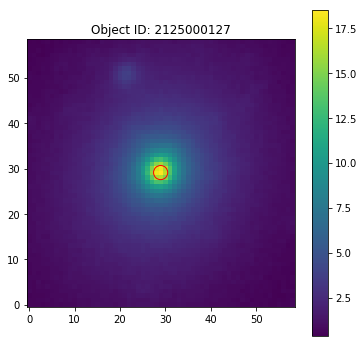

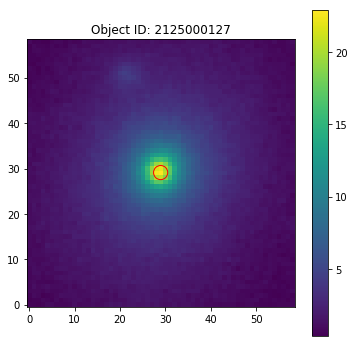

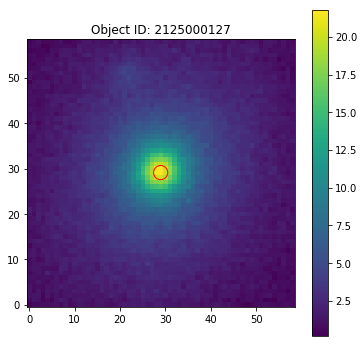

5


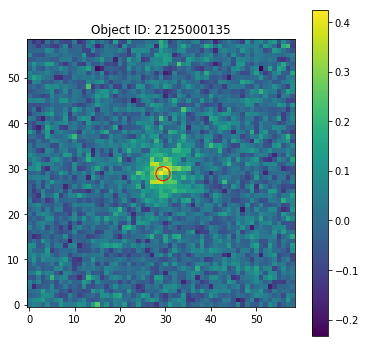

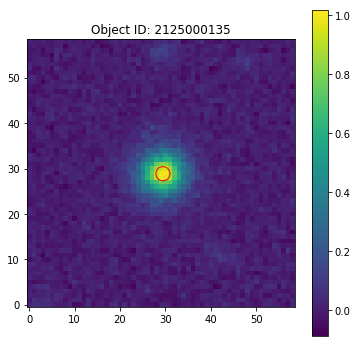

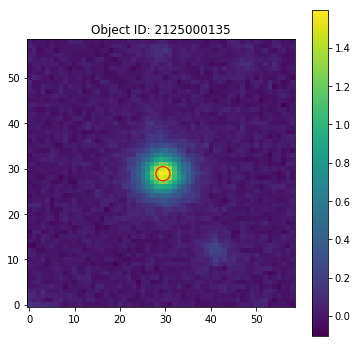

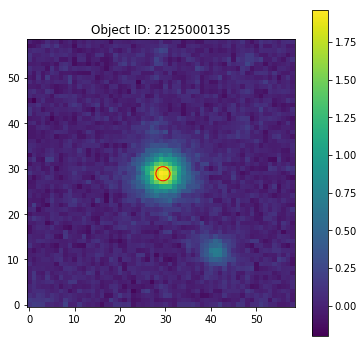

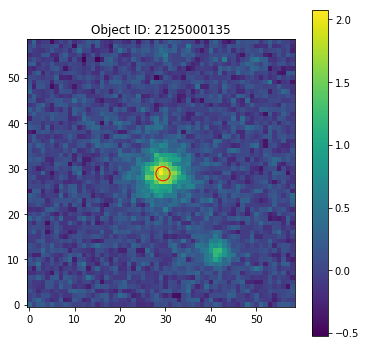

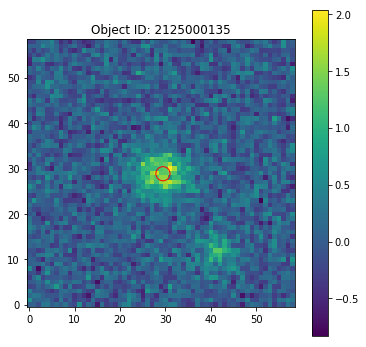

6


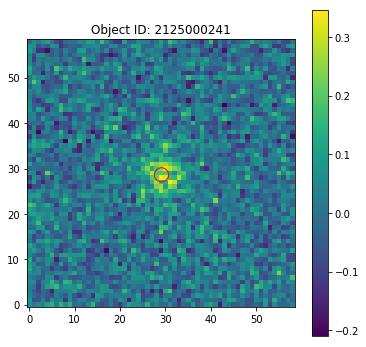

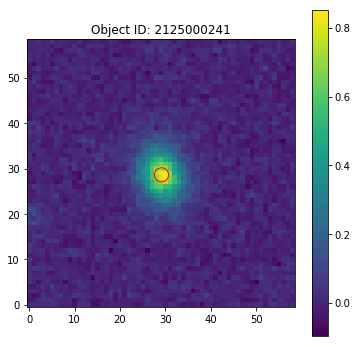

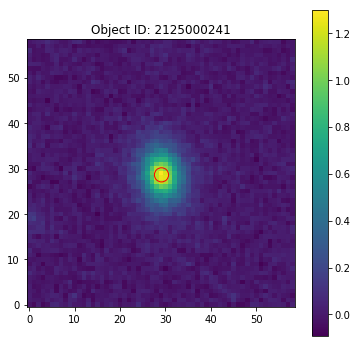

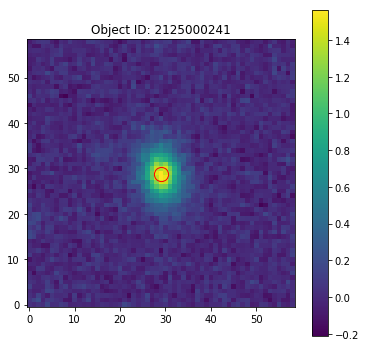

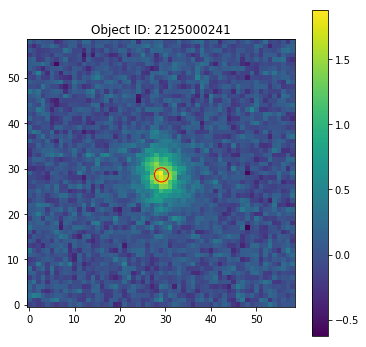

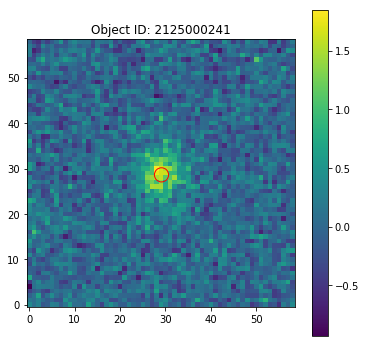

7


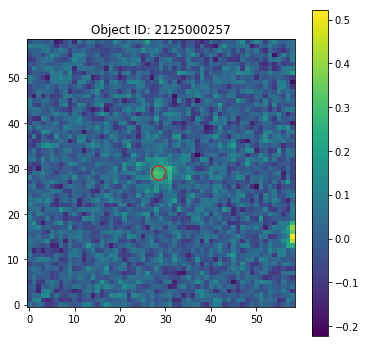

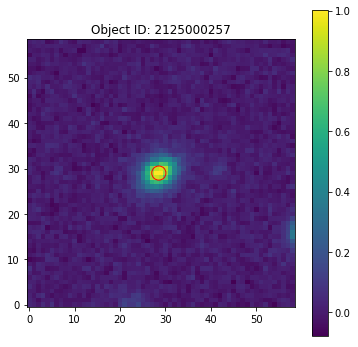

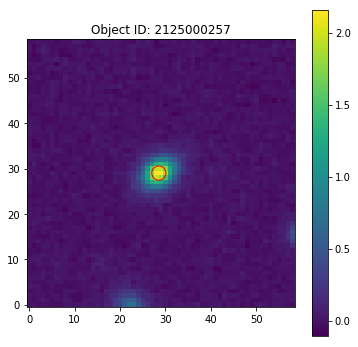

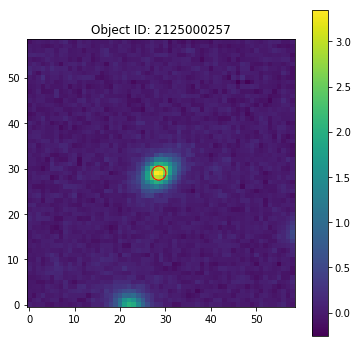

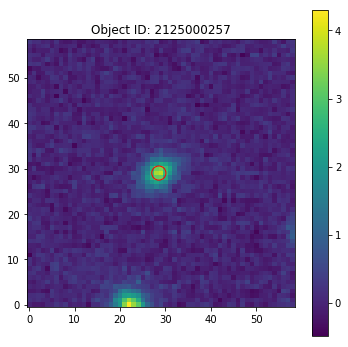

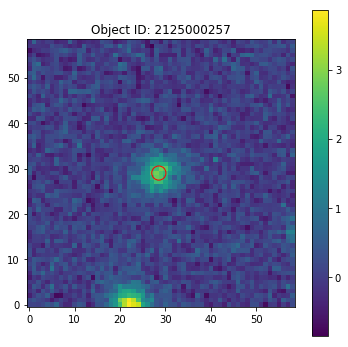

8


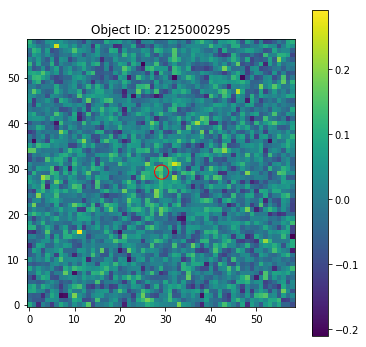

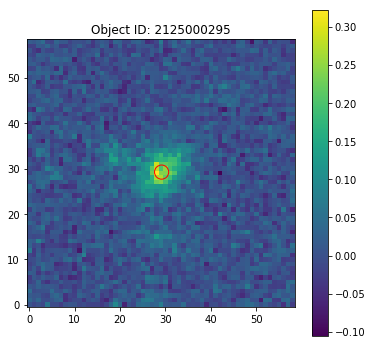

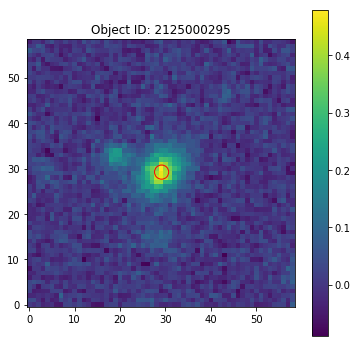

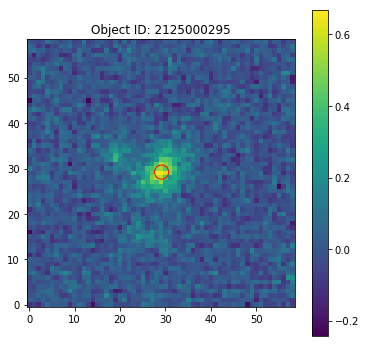

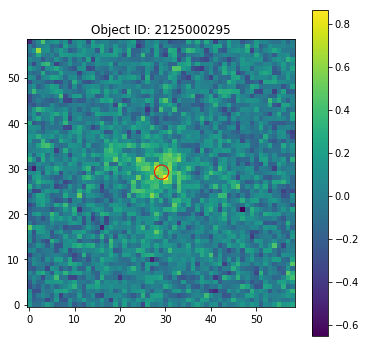

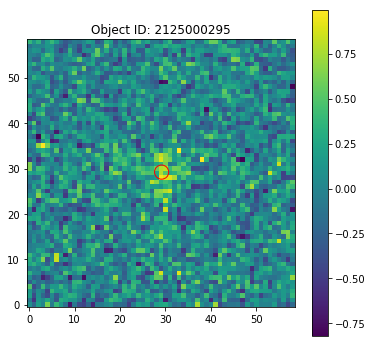

9


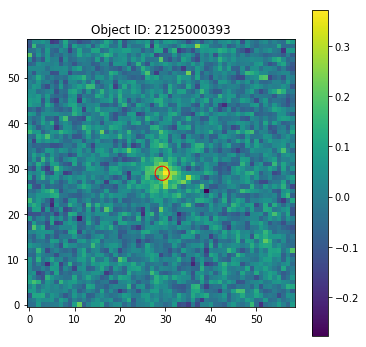

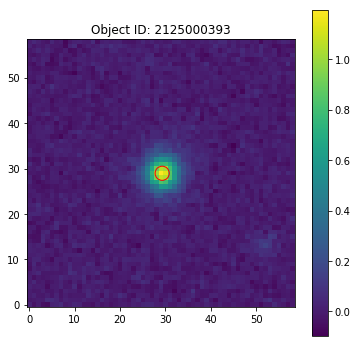

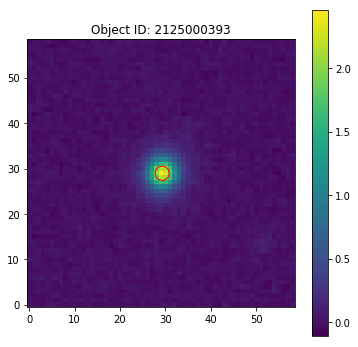

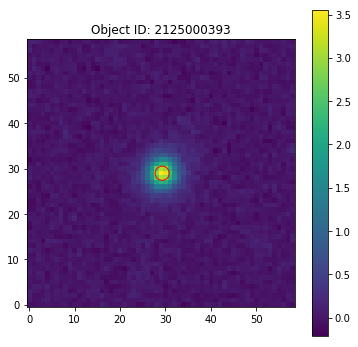

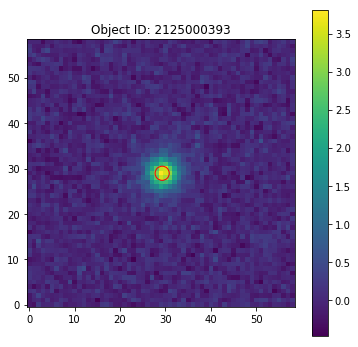

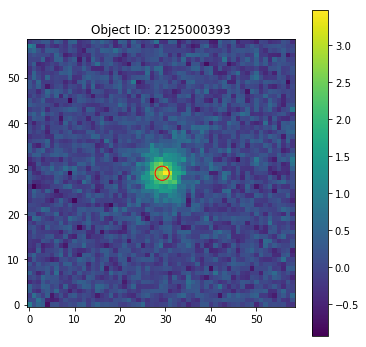

In [97]:
t_1 = time.time()
N = 10

img_sample = np.zeros((N,59,59,6))
psf_sample = np.zeros((N,59,59,6))

e1 = []
e2 = []
shear1=[]
shear2=[]
redshift=[]

for i in range (N):
    print(i)
    first = id_ra_dec[object_idx[i]]
    ra, dec = first['ra'], first['dec']
    # Necessary for PSF position
    radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

    frame = 0
    plt.figure(frame)
    
    img = np.zeros((59,59,6))
    psf = np.zeros((59,59,6))
    filters = ['u','g','r','i','z','y']
    for k, filter_k in enumerate (filters):
        if k == 0:
            cutout = cutout_img_dc2.make_cutout_image(butler_u, ra, dec, filter=filter_k, label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])
        else:
            cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter=filter_k, label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])
        img[:,:,k]= cutout.image.array
        psf[:,:,k]= cutout.getPsf().computeKernelImage(xy).array
    
    img_sample[i]=img
    psf_sample[i]=psf
    
    e1.append(truth_data['ellipticity_1_true'][truth_idx[i]])
    e2.append(truth_data['ellipticity_2_true'][truth_idx[i]])
    shear1.append(truth_data['shear_1'][truth_idx[i]])
    shear2.append(truth_data['shear_2'][truth_idx[i]])
    redshift.append(truth_data['redshift'][truth_idx[i]])
    
t_2 = time.time()

In [98]:
t_2-t_1

136.4356164932251

Without plotting images (not necessary here)

In [99]:
t_3 = time.time()
N = 20

img_sample = np.zeros((N,59,59,6))
psf_sample = np.zeros((N,59,59,6))

e1 = []
e2 = []
shear1=[]
shear2=[]
redshift=[]

for i in range (N):
    print(i)
    first = id_ra_dec[object_idx[i]]
    ra, dec = first['ra'], first['dec']
    # Necessary for PSF position
    radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

    frame = 0
    plt.figure(frame)
    
    img = np.zeros((59,59,6))
    psf = np.zeros((59,59,6))
    filters = ['u','g','r','i','z','y']
    for k, filter_k in enumerate (filters):
        if k == 0:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_u, ra, dec, filter=filter_k)
        else:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler, ra, dec, filter=filter_k)
        img[:,:,k]= cutout.image.array
        psf[:,:,k]= cutout.getPsf().computeKernelImage(xy).array
    
    img_sample[i]=img
    psf_sample[i]=psf
    
    e1.append(truth_data['ellipticity_1_true'][truth_idx[i]])
    e2.append(truth_data['ellipticity_2_true'][truth_idx[i]])
    shear1.append(truth_data['shear_1'][truth_idx[i]])
    shear2.append(truth_data['shear_2'][truth_idx[i]])
    redshift.append(truth_data['redshift'][truth_idx[i]])
    
t_4 = time.time()

print(t_4-t_3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
114.87254810333252


<Figure size 432x432 with 0 Axes>

Plot some images for test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


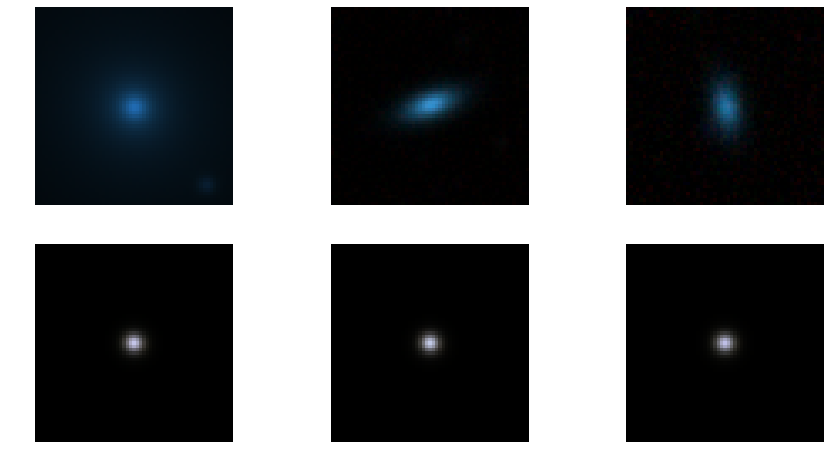

In [100]:
fig, axes  = plt.subplots(2,3, figsize = (15,8))

for i in range (3):
    # Image of galaxy scene
    plot.plot_rgb(img_sample[i]/np.max(img_sample[i]), bands=[0,1,2], ax=axes[0,i], band_first=False, zoom=1)
    # Corresponding PSF
    plot.plot_rgb(psf_sample[i]/np.max(psf_sample[i]), bands=[0,1,2], ax=axes[1,i], band_first=False, zoom=1)

# Load data generated with `generate_dc2_img.py`

In [101]:
img_gen = np.load('/sps/lsst/users/barcelin/data/dc2_test/img_sample.npy')
psf_gen = np.load('/sps/lsst/users/barcelin/data/dc2_test/psf_sample.npy')
data_gen = pd.read_csv('/sps/lsst/users/barcelin/data/dc2_test/img_data.csv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


e1: -0.2062443015674653
e2: 0.03760846461047155
redshift: 0.8009362750643003
e1: 0.1073675076506828
e2: -0.14605515213101938
redshift: 0.44477525809165175
e1: -0.09560859628606334
e2: -0.02798199737941472
redshift: 0.21960142564051036


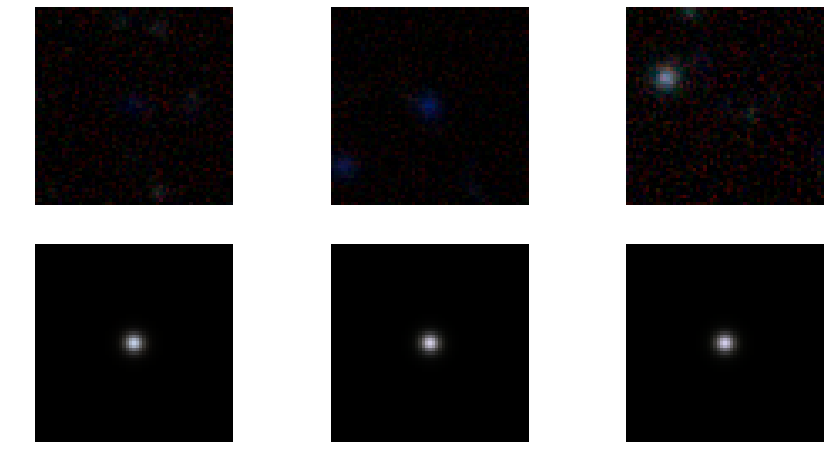

In [102]:
fig, axes  = plt.subplots(2,3, figsize = (15,8))

for i in range (3):
    # Image of galaxy scene
    plot.plot_rgb(img_gen[i]/np.max(img_gen[i]), bands=[0,1,2], ax=axes[0,i], band_first=False, zoom=1)
    # Corresponding PSF
    plot.plot_rgb(psf_gen[i]/np.max(psf_gen[i]), bands=[0,1,2], ax=axes[1,i], band_first=False, zoom=1)
    print('e1: '+str(data_gen['e1'][i]))
    print('e2: '+str(data_gen['e2'][i]))
    print('redshift: '+str(data_gen['redshift'][i]))

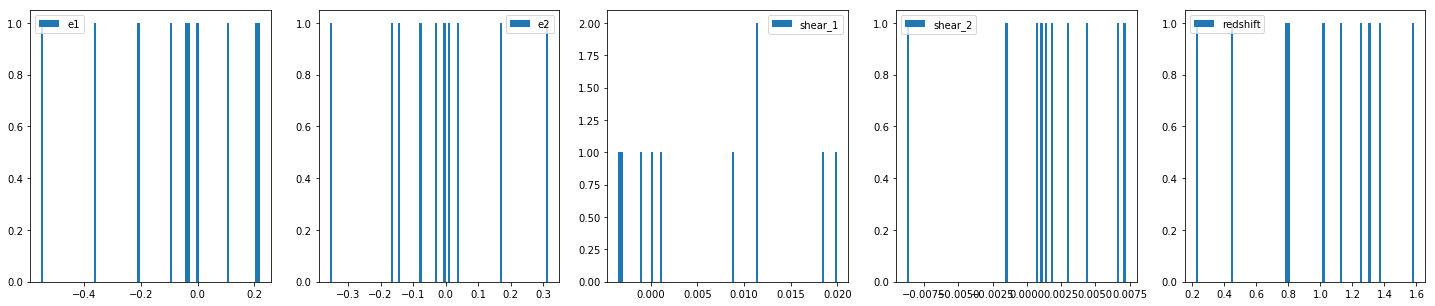

In [105]:
fig, axes = plt.subplots(1,5, figsize = (25,5))
_ = axes[0].hist(data_gen['e1'], bins = 100, label = 'e1')
_ = axes[1].hist(data_gen['e2'], bins = 100, label = 'e2')
_ = axes[2].hist(data_gen['shear_1'], bins = 100, label = 'shear_1')
_ = axes[3].hist(data_gen['shear_2'], bins = 100, label = 'shear_2')
_ = axes[4].hist(data_gen['redshift'], bins = 100, label = 'redshift')

for i in range (5):
    axes[i].legend()


In [19]:
img_gen = np.load('/sps/lsst/users/barcelin/data/dc2_test/training/img_sample.npy', mmap_mode = 'c')
psf_gen = np.load('/sps/lsst/users/barcelin/data/dc2_test/training/psf_sample.npy', mmap_mode = 'c')
data_gen = pd.read_csv('/sps/lsst/users/barcelin/data/dc2_test/training/img_data.csv')

e1: 0.0007750328054267332
e2: -0.0013124113101759475
redshift: 2.203812141394668
e1: -0.1851922725329144
e2: -0.16954559898754398
redshift: 0.794173545753043
e1: -0.013676126228901068
e2: 0.0032547435965230263
redshift: 2.3673663135745477


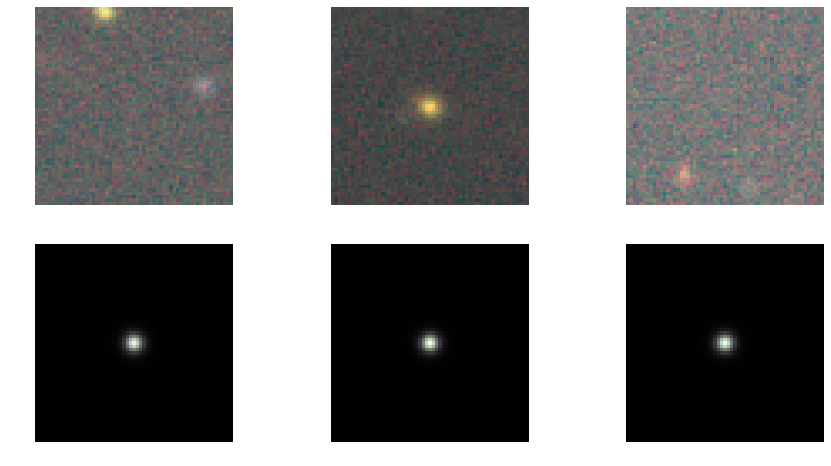

In [23]:
fig, axes  = plt.subplots(2,3, figsize = (15,8))

for i in range (3):
    # Image of galaxy scene
    img_gen[i+10] -= np.min(img_gen[i+10])
    plot.plot_rgb(img_gen[i+10]/np.max(img_gen[i+10]), bands=[4,3,1], ax=axes[0,i], band_first=False, zoom=1)
    # Corresponding PSF
    psf_gen[i+10] -= np.min(psf_gen[i+10])
    plot.plot_rgb(psf_gen[i+10]/np.max(psf_gen[i+10]), bands=[4,3,1], ax=axes[1,i], band_first=False, zoom=1)
    print('e1: '+str(data_gen['e1'][i+10]))
    print('e2: '+str(data_gen['e2'][i+10]))
    print('redshift: '+str(data_gen['redshift'][i+10]))

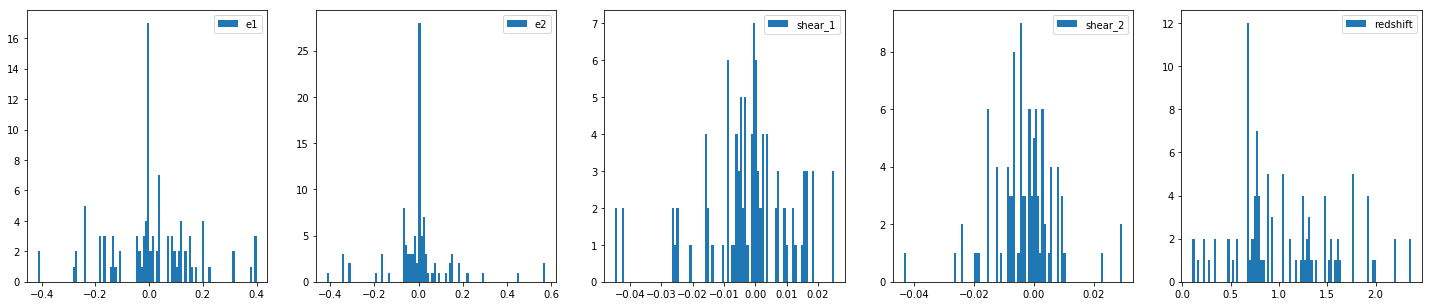

In [24]:
fig, axes = plt.subplots(1,5, figsize = (25,5))
_ = axes[0].hist(data_gen['e1'], bins = 100, label = 'e1')
_ = axes[1].hist(data_gen['e2'], bins = 100, label = 'e2')
_ = axes[2].hist(data_gen['shear_1'], bins = 100, label = 'shear_1')
_ = axes[3].hist(data_gen['shear_2'], bins = 100, label = 'shear_2')
_ = axes[4].hist(data_gen['redshift'], bins = 100, label = 'redshift')

for i in range (5):
    axes[i].legend()


### Voir pourquoi differentes valeurs de magnitude, et comment sont calculées les valeurs d'ellipticités vraies

In [106]:
img_gen = np.load('/sps/lsst/users/barcelin/data/dc2_test/img_sample.npy', mmap_mode = 'c')
psf_gen = np.load('/sps/lsst/users/barcelin/data/dc2_test/psf_sample.npy', mmap_mode = 'c')
data_gen = pd.read_csv('/sps/lsst/users/barcelin/data/dc2_test/img_data.csv')

In [108]:
img_gen.shape

(10, 59, 59, 6)

In [ ]:
N =1000

In [ ]:
len(truth_idx)

In [ ]:
indices = np.random.choice(list(range(len(truth_idx))), size=N, replace=False)

In [ ]:
indices